# Episode-2

    0 : land_x 0, land_y 100
    1 : land_x 1000, land_y 500
    2 : land_x 1500, land_y 1500
    3 : land_x 3000, land_y 1000
    4 : land_x 4000, land_y 150
    5 : land_x 5500, land_y 150
    6 : land_x 6999, land_y 800
    

In [1]:
# 抓進 peforth 以及外加功能
%run forth.py

reDef unknown
reDef -->
p e f o r t h    v1.26
source code http://github.com/hcchengithub/peforth
Type 'peforth.ok()' to enter forth interpreter, 'exit' to come back.



In [2]:
%pylab
# import numpy as np
from typing import List, Optional, Callable, Tuple, Dict, Union  # OneNote2021 #_python_ #_typing_
GENE = List[int]  # (rotate (-15 ~ +15),power (-1, 0, +1)) 避免無用的值域，下給 Web site 的 command 要轉換成 (rotate(-90 ~ +90), power(0,1,2,3,4))
GENOME = List[GENE]  # Genome 是一個 list 裡面都是 int
STATE = Dict[str,Union[int,float,np.array]]  # x,y,hspeed,power,.. etc 

import random, json, math, copy
from itertools import permutations  # permutations 數學「排列組合」中的「排列」
import IPython

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


# How to check if two given line segments intersect?
兩線相交的偵測程式。 A Python3 program to find if 2 given line segments intersect or not.

https://www.geeksforgeeks.org/check-if-two-given-line-segments-intersect/

In [3]:
# Given three colinear 共線 points p, q, r, 如果非共線就不準了，目的是看 q 是否在 p-r 之內，飛出 p-r 線外的不適用。
# the function checks if point q lies on line segment 'pr'
def onSegment(p, q, r):
	if ( (q.x <= max(p.x, r.x)) and (q.x >= min(p.x, r.x)) and
		(q.y <= max(p.y, r.y)) and (q.y >= min(p.y, r.y))):
		return True
	return False

In [4]:
def orientation(p, q, r):
	# to find the orientation of an ordered triplet (p,q,r) 有序三元組
	# function returns the following values:
	# 0 : Colinear points 喔！共線靠這個也能界定。
	# 1 : Clockwise points
	# 2 : Counterclockwise
	
	# See https://www.geeksforgeeks.org/orientation-3-ordered-points/amp/
	# for details of below formula.
	
	val = (float(q.y - p.y) * (r.x - q.x)) - (float(q.x - p.x) * (r.y - q.y))
	if (val > 0):
		
		# Clockwise orientation
		return 1
	elif (val < 0):
		
		# Counterclockwise orientation
		return 2
	else:
		
		# Colinear orientation
		return 0

In [5]:
# The main function that returns true if
# the line segment 'p1q1' and 'p2q2' intersect.
def doIntersect(p1,q1,p2,q2):
	
	# Find the 4 orientations required for
	# the general and special cases
	o1 = orientation(p1, q1, p2)
	o2 = orientation(p1, q1, q2)
	o3 = orientation(p2, q2, p1)
	o4 = orientation(p2, q2, q1)

	# General case
	if ((o1 != o2) and (o3 != o4)):
		return True

	# Special Cases

	# p1 , q1 and p2 are colinear and p2 lies on segment p1q1
	if ((o1 == 0) and onSegment(p1, p2, q1)):
		return True

	# p1 , q1 and q2 are colinear and q2 lies on segment p1q1
	if ((o2 == 0) and onSegment(p1, q2, q1)):
		return True

	# p2 , q2 and p1 are colinear and p1 lies on segment p2q2
	if ((o3 == 0) and onSegment(p2, p1, q2)):
		return True

	# p2 , q2 and q1 are colinear and q1 lies on segment p2q2
	if ((o4 == 0) and onSegment(p2, q1, q2)):
		return True

	# If none of the cases
	return False

### 點到線段的距離

In [6]:
# Calculate the euclidian distance between an array of points to a line segment in Python without for loop
# https://stackoverflow.com/questions/54442057/calculate-the-euclidian-distance-between-an-array-of-points-to-a-line-segment-in
# OneDrive/文件/Jupyter Notebooks/Differences of np.dot and np.multiply/intro_2_vector.ipynb
# lineseg_dists(p:[Vector], a:Vector, b:Vector) -> [float]

def lineseg_dists(p, a, b):
    # where p is an array of points, a,b is the line segment
    # lineseg_dists(p:[Vector], a:Vector, b:Vector) -> [float]
    
    if np.all(a == b):
        return np.linalg.norm(p - a, axis=1)  # a-b 是一個點，直接取 p-a 就是答案。 p 

    # normalized tangent vector
    d = np.divide(b - a, np.linalg.norm(b - a))

    # signed parallel distance components
    s = np.dot(a - p, d)  # a-p 在 d 上的投影
    t = np.dot(p - b, d)  # p-b 在 d 上的投影

    # clamped parallel distance
    h = np.maximum.reduce([s, t, np.zeros(len(p))])  # h 是
    
    # perpendicular distance component, as before
    # note that for the 3D case these will be vectors
    c = np.cross(p - a, d)

    # use hypot for Pythagoras to improve accuracy
    result = np.hypot(h, c)
    
    return result

# 點 [1,1] 在線的右上邊，距離是正的；點 [0,0] 在線的左下邊，距離也是正的，所以它沒有分正負。
p = np.array([[1,1],[0,0]])  # the point
a = np.array([1,0])  # the line start
b = np.array([0,1])  # the line end
distance = lineseg_dists(p, a, b)
%f distance -->

# 這組實驗證實 lineseg_dists() 無誤
p = np.array([[-1,0.5],[0,0],[0,0.5],[0.5,0.5],[1,0],[1,0.5],[2,0.5]])  # the point
a = np.array([0,0])  # the line start
b = np.array([1,0])  # the line end
distance = lineseg_dists(p, a, b)
%f distance -->

distance --> [0.70710678 0.70710678] (<class 'numpy.ndarray'>)
distance --> [1.11803399 0.         0.5        0.5        0.         0.5
 1.11803399] (<class 'numpy.ndarray'>)


# 直接讀 log 檔
So the `%store log` is from here

# 最基本的定義 

In [7]:
Gravity = 3.711        # constant on Mars
G = Gravity             # 到了二維以上，重力需轉成向量
Altitude = 150          # altitude of the flat 
VSpeed = 40             # target virtical speed 
HSpeed = 20             # target horizental speed 
Fuel0 = 550             # episode-2
Flat_ground = 4
Land = [
  [   0, 100], # 0
  [1000, 500], # 1
  [1500,1500], # 2
  [3000,1000], # 3
  [4000, 150], # 4 flat ground
  [5500, 150], # 5 flat ground
  [6999, 800], # 6
]    


# Parameters
Round_off = 2           # 顯示到小數點以下兩位避免太長


In [8]:

# Vector 比 np.array 好一點在於有 __str__ 可以做 round-off 輸出。

class Vector:
    def __init__(self, x:float,y:float):
        self.x = x
        self.y = y

    def __mul__(self, x:float):
        m = self.v() * x 
        return Vector(*m)  # Vector(m[0], m[1])  np.array 也可以直接 unpack or distructing 
    
    def __add__(self, x):
        m = self.v() + x.v() 
        return Vector(*m)  # Vector(m[0], m[1])  np.array 也可以直接 unpack or distructing 

    def v(self) -> np.array:
        # A vector is a np.array
        return np.array([self.x,self.y])

    def n(self) -> float:
        # norm of a vector is its length
        return np.linalg.norm(self.v())

    def u(self) -> np.array:
        # Shrink the given vector into an unit vector. https://stackoverflow.com/questions/21030391/how-to-normalize-an-array-in-numpy
        return self if round(self.n(),6) == 0. else self.v()/self.n();  # 考慮周詳
    
    def __str__(self) -> str:
        return 'Vec' + str(np.array([round(self.x,Round_off),round(self.y,Round_off)]))
    
%f Vector :> (3,4) -->
%f Vector :> (3,4).v() -->
%f Vector :> (3,4).x -->
%f Vector :> (3,4).y -->
%f Vector :> (3,4).n() -->
%f Vector :> (3,4).u() -->
%f Vector :> (0.6,0.8).n() -->
%f Vector :> (0.6,0.8)*2 -->    

Vector :> (3,4) --> Vec[3 4] (<class '__main__.Vector'>)
Vector :> (3,4).v() --> [3 4] (<class 'numpy.ndarray'>)
Vector :> (3,4).x --> 3 (<class 'int'>)
Vector :> (3,4).y --> 4 (<class 'int'>)
Vector :> (3,4).n() --> 5.0 (<class 'numpy.float64'>)
Vector :> (3,4).u() --> [0.6 0.8] (<class 'numpy.ndarray'>)
Vector :> (0.6,0.8).n() --> 1.0 (<class 'numpy.float64'>)
Vector :> (0.6,0.8)*2 --> Vec[1.2 1.6] (<class '__main__.Vector'>)


In [9]:
class Angle(Vector):
    def __init__(self, an:float) -> Vector:
        # Convert the given absolute angle in degrees to a unit vector that represents the angle
        v = Vector(math.cos(np.deg2rad(an + 90)), math.sin(np.deg2rad(an + 90)))
        self.x, self.y = v.x, v.y  # 已經是單位向量，無須這樣 v.u()[0], v.u()[1] 

%f Angle :> (-180) :> v() -->
%f Angle :> (-180) -->
%f Angle :> (90)   -->
%f Angle :> (-90)  -->   
%f Angle :> (180)  -->   
%f Angle :> (45)   -->   
%f Angle :> (-45)  -->   
%f Angle :> (-45) type -->   
    

Angle :> (-180) :> v() --> [ 6.123234e-17 -1.000000e+00] (<class 'numpy.ndarray'>)
Angle :> (-180) --> Vec[ 0. -1.] (<class '__main__.Angle'>)
Angle :> (90)   --> Vec[-1.  0.] (<class '__main__.Angle'>)
Angle :> (-90)  --> Vec[1. 0.] (<class '__main__.Angle'>)
Angle :> (180)  --> Vec[-0. -1.] (<class '__main__.Angle'>)
Angle :> (45)   --> Vec[-0.71  0.71] (<class '__main__.Angle'>)
Angle :> (-45)  --> Vec[0.71 0.71] (<class '__main__.Angle'>)
Angle :> (-45) type --> <class '__main__.Angle'> (<class 'type'>)


In [10]:
G = Angle(180) * Gravity  # G = Vector(*(Angle(180).v() * Gravity)) 我有提供 __mul__ 

%f G -->
%f G type --> 


G --> Vec[-0.   -3.71] (<class '__main__.Vector'>)
G type --> <class '__main__.Vector'> (<class 'type'>)


In [11]:
# 最近兩個位置與 surface 比對看是否已經觸地
def isLanded(p0, p1):
    landed = False
    for j in range(len(Land)-1): # consider all surfaces
        if doIntersect(p0,p1,Vector(*Land[j]),Vector(*Land[j+1])):
            landed = True
            break
    return {"surface":j,"landed":landed}  # 傳回 surface 方便 test and debug.

p0 = Vector(2500,3000) # 試試看下一個 surface 
p1 = Vector(2500,3001) # 試試看下一個 surface 
print(isLanded(p0, p1))

{'surface': 5, 'landed': False}


In [12]:

# State 的 properties 都用 python 的原型，不用 np.array 之類。原因，感覺較單純不會有意外。

class State():

    def __init__(self, step=0, x=2500, y=2700, hspeed=0, vspeed=0, 
                 fuel=550, angle=0, power=0, **kwargs):
        self.step   = step
        self.x      = x
        self.y      = y
        self.hspeed = hspeed
        self.vspeed = vspeed
        self.fuel   = fuel
        self.angle  = angle
        self.power  = power
        self.trace  = [[x,y]]
        self.landed = False
        # self.force  = G + Angle(self.angle)*self.power

    def next(self, angle:int, power:int):  
        # input angle,power 都是 offset differential delta 分別屬 -15~15 以及 -1,0,+1 
        assert power in [-1, 0, 1], 'expected input power [-1, 0, +1], given {}'.format(power)
        assert angle in range(-15,16), 'input angle range [-15:16], given {}'.format(angle)
        self.step   += 1
        self.angle  += angle
        self.angle   = -90 if self.angle < -90 else self.angle
        self.angle   =  90 if self.angle > 90 else self.angle
        self.power  += power
        self.power   = 0 if self.power < 0 else self.power
        self.power   = 4 if self.power > 4 else self.power
        self.fuel   -= self.power
     #  self.x       = self.x       # episode-1 不變
     #  self.y       = self.y + self.vspeed + (1/2)*self.force
     #  self.hspeed  = self.hspeed  # episode-1 不變
     #  self.vspeed += self.force
        force = G + Angle(self.angle)*self.power  # force on the ship during this step         
        s0 = Vector(self.hspeed,self.vspeed)
        p0 = Vector(self.x,self.y)
        s1 = s0 + force 
        p1 = p0 + s0 + force*0.5
        self.x, self.y = p1.x, p1.y
        self.hspeed, self.vspeed = s1.x, s1.y
        self.landed = self.landed or isLanded(p0,p1)['landed']
        self.trace.append([self.x,self.y])
        return self  # 傳回值只是好測試，以便於可以這樣寫： %f state :> next(0,3.711) -->

    def __str__(self):  
        d = copy.deepcopy(self.__dict__)
        return str([{k:int(round(v,0))} for k,v in d.items() if k != 'trace'])

state0 = State(0,2500,2700,0,0,Fuel0,0,0)  # episode-2 的起點 state
%f state0 -->

state0 --> [{'step': 0}, {'x': 2500}, {'y': 2700}, {'hspeed': 0}, {'vspeed': 0}, {'fuel': 550}, {'angle': 0}, {'power': 0}, {'landed': 0}] (<class '__main__.State'>)


In [13]:
# 弄出 genome0 跑去墜毀，試驗相關的 functions 
state = State(**state0.__dict__)
genome0 = []
genome0.append([-15,1]); state.next(*genome0[-1]) 
genome0.append([ -5,1]); state.next(*genome0[-1]) 
genome0.append([  0,1]); state.next(*genome0[-1]) 
for i in range(3,100):  # 已知不到 100 用 while True 也行，用 for 比較保險
    genome0.append([0,0]);state.next(*genome0[-1])
    if i == 71: state72 = copy.deepcopy(state)
    if state.landed: 
        break       
%f state -->
%f \ state72 -->
%f \ genome0 -->
%f \ state :> trace -->
        

state --> [{'step': 73}, {'x': 5154}, {'y': 122}, {'hspeed': 74}, {'vspeed': -68}, {'fuel': 334}, {'angle': -20}, {'power': 3}, {'landed': 1}] (<class '__main__.State'>)


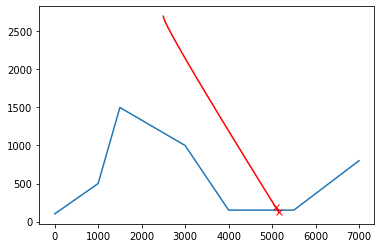

In [14]:
%matplotlib inline
x = [0, 1000, 1500, 3000, 4000, 5500, 6999]
y = [100, 500, 1500, 1000, 150, 150, 800]
# plt.plot(x,y,'',thread[:,0],thread[:,1],'r',thread[-2:,0],thread[-2:,1],'rx');  # 這行等於以下三行，三個 args 一組。
plt.plot(x,y,'')  # 地形
plt.plot(np.array(state.trace)[:,0],np.array(state.trace)[:,1],'r')  # 整條 trace 
plt.plot(np.array(state.trace)[-2:,0],np.array(state.trace)[-2:,1],'rx');  # 最後兩點打上標記


# get_random_neighbour()

Mars Lander 的 genome 很簡單，就是一串 (angle:int,power:int) pairs. 前面基礎討論有提到，以 SA 而言就是 mutate 某一個 gene 也就是 command pair 而已。Mutation 的改變要做的決定是 power `[-1 0 +1]`、angle `[-15 +15
]` 而非 `0 ~ 4`、`-90 ~ +90` 以確保 mutating 有效。

### 要點
- 太長而無效的 genes 要 cut 掉。
- 長度不夠時直接 copy 最後一個 gene 頂替即可。
- 會發現 genome 太長或不夠的是 simulator 那就是由它處理。
- 避免無效的 neighbour 例如前一 power 是 0 或 4 卻下 -1 或 1 就是無效的，這個 neighbour 就浪費了。 
- 第一個 gene 的 power 不能下 -1 只能下 0 或 +1 , 將來 angle 也有一樣的限制。

In [15]:
# 把 genome 轉成 codingame web 接受的 command list 
def genome_to_command_list(genome:GENOME) -> List[List[int]] :
    a,p,r = 0,0,[]  # declare angle, power, and results: command array of [angle,power] paris
    for i in genome :
        if i[0] >=0 : a = min(a+i[0], 90)  # angle 0~15 degree
        else: a = max(a+i[0],-90)  # angle -15 ~ 0 degree
        if i[1] == -1 : p = max(p-1, 0) 
        elif i [1] == 1 : p = min(p+1, 4) 
        r.append([a, p])
    return r

%f genome0 genome_to_command_list :> (pop()) -->


genome0 genome_to_command_list :> (pop()) --> [[-15, 1], [-20, 2], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3], [-20, 3]] (<class 'list'>)


In [16]:
def get_random_neighbour(genome: GENOME) -> GENOME :
    neighbour = copy.deepcopy(genome)  # 利用 [:] slice copy 不行，因為 elements 又是 array！ 
    commands = genome_to_command_list(neighbour)  # 絕對 command, 用來檢查前一狀態避免產生無效的 neighbour 
    
    while True:  # 試到不一樣了才出來
        idx = random.randint(0,len(genome)-1) # 選 1 個 gene 
        cmd = random.randint(0,1) # pwr or ang 選 1 個
        if cmd:
            pwr = random.randint(-1, 1)  # -1, 0, +1 當中選 1 個 thrust command (episode-1)
            if idx == 0 and pwr == -1 : continue  # 一開始的 power 就是 0 再下 -1 無效
            if idx >= 1 and pwr == -1 and commands[idx-1][1] == 0: continue  # 前一個 power 就已經是 0 又下 -1 無效
            if idx >= 1 and pwr ==  1 and commands[idx-1][1] == 4: continue  # 前一個 power 就已經是 4 又下 +1 無效
            if neighbour[idx][1] == pwr : continue  # 沒有變化當然無效
            else: 
                neighbour[idx][1] = pwr
                break
        else:
            ang = random.randint(-15, 15)  # -15~+15 當中選 1 個 thrust command (episode-1)
            if (commands[idx-1][0] + ang) > 90 or (commands[idx-1][0] + ang) < -90 : continue # angle0 + angle 超過限度
            if neighbour[idx][0] == ang: continue  # 沒有變化當然無效
            else: 
                neighbour[idx][0] = ang 
                break
    return neighbour

# 仔細檢查
for i in range(2): # actually 500 以便觀察是否每種可能都有出現
    %f get_random_neighbour :> ([[0,1],[0,1],[0,1],[0,1],[0,1]]) --> \ gene0 pwr 只有 0 或 1 不會有 -1, gene1 視 gene0 而定     


get_random_neighbour :> ([[0,1],[0,1],[0,1],[0,1],[0,1]]) --> [[0, 1], [0, 1], [0, 1], [0, 1], [-4, 1]] (<class 'list'>)
get_random_neighbour :> ([[0,1],[0,1],[0,1],[0,1],[0,1]]) --> [[0, 1], [0, 1], [0, 1], [-7, 1], [0, 1]] (<class 'list'>)


# cost_of_state(state: STATE)
- 成功著陸的，油料剩越多的越好。
- 根據我之前對 y=100 (flat ground 的海拔高度) 的研究 該 state 來自 log 的最後一 state. 當 Simulating 時，該 state 就是 y 首次跨越 flat ground 高度觸地著陸之時，跨越！僅用高度來判斷只有 episode-1 能用： round(state.y,0) < Altitude; 若 round(state.y,0) <= Altitude 則 100.45 也會被錯當成已著陸，錯誤。
- 一個油料耗盡一個墜毀哪個好？墜毀時的速度減到+-40 (VSpeed) 以內需要多少油料？
- 油料耗盡時的高度距離與速度以自由落體觸地 (垂直位置)，記錄觸地時的 state 分幾次重複模擬把 (垂直速度)、(水平速度)、(水平位置) 分別修正好所需的油料。
    - 全力往 0 度方向噴火把 vspeed 速度調整到 +-VSpeed 以內需要多少油料？
    - 全力往 +-90 度方向噴火把 hspeed 速度調整到 +-HSpeed 以內需要多少油料？
    - 全力往 +-90 度方向噴火把 position 調整到 flat ground 境內需要多少油料？
- 做實驗證實：在最後一步才突然下不同命令 (angle,power) 對以上方法所得到的分數有正確的差別。
- cost 必大於 0。 Score 用油料剩餘量計算
，由 fuel0 扣下來可到負值。換算成 cost 就是 cost = fuel0 - score. 核算，當 score 為 fuel0 時 cost 為 0 無誤； 當 score 為 -fuel0 時 cost 為 2fuel0
  甚至更高，也無誤。 直接用這個數字，配合 SA 的 Temperature 設定要用 visualized graphs 來訂定 即可。


In [17]:
def cost_of_vspeed(state: STATE) -> int:
    # 必須觸地了才 call 本 function，把垂直方向的 vspeed 修正到目標速度內，計算這部分成績。
    state = copy.deepcopy(state)  # 不要去動到原來的
    fuel0 = state.fuel;
    while state.vspeed < -VSpeed: # 剛從空中下來觸地， vspeed 一定是負值；墜毀的一定比 -VSpeed 小
        a = 0 - state.angle  # 目標角度是 0 度
        a = min(a,15) if a >= 0 else max(a,-15)
        state.next(a,1)  # 擺正全力噴火
    cost = fuel0 - state.fuel
    return {"cost":cost,"state":state}

%f state cost_of_vspeed :> (pop()) -->


state cost_of_vspeed :> (pop()) --> {'cost': 388, 'state': <__main__.State object at 0x00000173821363C8>} (<class 'dict'>)


In [18]:
def cost_of_hspeed(state: STATE) -> int:
    # 必須觸地了才 call 本 function，把水平方向的 hspeed 修正到目標速度內，計算這部分成績。
    state = copy.deepcopy(state)  # 不要去動到原來的
    fuel0 = state.fuel;
    direction = 15 if state.hspeed >= 0 else -15  # 正向速度過快要用 +90 角全力噴火減速，反之則 -90 度角。
    while abs(state.hspeed) > HSpeed:
        state.next(direction,1)
    cost = fuel0 - state.fuel
    return  {"cost":cost,"state":state}

%f state cost_of_hspeed :> (pop()) -->


state cost_of_hspeed :> (pop()) --> {'cost': 68, 'state': <__main__.State object at 0x00000173821AE688>} (<class 'dict'>)


In [19]:
def cost_of_hposition(state: STATE) -> int:
    # 必須觸地了才 call 本 function，把水平位置修正到目標速度內，計算這部分成績。
    state = copy.deepcopy(state)  # 不要去動到原來的
    fuel0 = state.fuel;
    # 正向速度過快要用 +90 角全力噴火減速，反之則 -90 度角。
    direction = 0
    if state.x < Land[Flat_ground][0]: direction = -15
    if state.x > Land[Flat_ground+1][0]: direction = 15
    while state.x < Land[Flat_ground][0] or state.x > Land[Flat_ground+1][0]:
        state.next(direction,1)
    cost = fuel0 - state.fuel
    return  {"cost":cost,"state":state}

%f state cost_of_hposition :> (pop()) -->


state cost_of_hposition :> (pop()) --> {'cost': 0, 'state': <__main__.State object at 0x00000173821B4288>} (<class 'dict'>)


In [20]:
def cost_of_state(state: STATE) -> int:
    state = copy.deepcopy(state)  # 不要去動到原來的
    # 先判斷是否觸地。若未觸地就是飛走了或油料耗盡。
    if not state.landed:
        while True: 
            state.next(0,-1)  # 半空中開始模擬 free fall, 小心別又錯了，不是直接填 0 ！！
            if state.landed: break
    costs = {"vspeed":cost_of_vspeed(state),"hspeed":cost_of_hspeed(state),"hposition":cost_of_hposition(state)}
    cost = costs["vspeed"]["cost"] +costs["hspeed"]["cost"] + costs["hposition"]["cost"] - state.fuel
    return {"cost":cost,"costs":costs}

%f state -->
%f state cost_of_state :> (pop()) >x x@ :> ['cost'] --> # 這個的 cost 是 122, state0 是 578 
%f x@ :> ['costs']['vspeed']['state'] -->
%f x@ :> ['costs']['hspeed']['state'] -->
%f x@ :> ['costs']['hposition']['state'] -->


state --> [{'step': 73}, {'x': 5154}, {'y': 122}, {'hspeed': 74}, {'vspeed': -68}, {'fuel': 334}, {'angle': -20}, {'power': 3}, {'landed': 1}] (<class '__main__.State'>)
state cost_of_state :> (pop()) >x x@ :> ['cost'] --> 122 (<class 'int'>)
這個的 cost 是 122, state0 是 578

x@ :> ['costs']['vspeed']['state'] --> [{'step': 170}, {'x': 12345}, {'y': -5107}, {'hspeed': 74}, {'vspeed': -40}, {'fuel': -54}, {'angle': 0}, {'power': 4}, {'landed': 1}] (<class '__main__.State'>)
x@ :> ['costs']['hspeed']['state'] --> [{'step': 90}, {'x': 6018}, {'y': -1300}, {'hspeed': 18}, {'vspeed': -112}, {'fuel': 266}, {'angle': 90}, {'power': 4}, {'landed': 1}] (<class '__main__.State'>)
x@ :> ['costs']['hposition']['state'] --> [{'step': 73}, {'x': 5154}, {'y': 122}, {'hspeed': 74}, {'vspeed': -68}, {'fuel': 334}, {'angle': -20}, {'power': 3}, {'landed': 1}] (<class '__main__.State'>)


In [21]:
%f state0 cost_of_state :> (pop()) >x x@ :> ['cost'] --> # state0 是 578 
       

state0 cost_of_state :> (pop()) >x x@ :> ['cost'] --> 578 (<class 'int'>)
state0 是 578



In [22]:
%f state72 cost_of_state :> (pop()) >x x@ :> ['cost'] --> # state72 是 147 果然不如 122 

state72 cost_of_state :> (pop()) >x x@ :> ['cost'] --> 147 (<class 'int'>)
state72 是 147 果然不如 122



# 演練手動產生 random neighbour 比分

In [29]:
# 模擬試跑 genome. Genome 可能太長或不夠，傳回訂正好的 genome 以及最後 state  
def simulate_of_genome(input_genome: GENOME) -> Tuple[GENOME,STATE]:
    genome = copy.deepcopy(input_genome)  # make a copy to isolate the original
    state = State(**state0.__dict__)  # init state for simulation
    # 照 genome 跑到觸地、飛走、或油料耗盡時為止， genome 可能含有無效的長度要 cut 掉以免浪費時間嘗試。
    for i in range(len(genome)): 
        state.next(*genome[i])  # run 1 step 
        if state.landed or \
           state.y >= 3000 or state.x >= 7000 or \
           state.y <= 0 or state.x <= 0 or \
           state.fuel <= 0: # 這高度、油料、位置不能再繼續了
            genome = genome[:i+1]  # 太長的尾巴切掉
            break
        
    # 接續以上跑完 input genome 之後的 state 看看 input genome 是否太短需要補綴 genes 讓 lander 觸地。
    # 因為 genome 是 get_random_neighbour() 產生的，我們不想弄個沒意義的 neighbour 浪費時間，所以要盡
    # 力把它補好。熄火或照抄？照抄，有作為比較符合需要。不怕 infinit loop 因為油料有限。
    while not state.landed and state.fuel > 0 and \
           state.y < 3000 and state.x < 7000 and \
           state.y > 0 and state.x > 0 :
        genome.append(genome[-1][:])  # 注意！若不用 [:] slice copy 則 append 進去的都是同一個。gene 是個 shallow array 無誤，可以用 slice copy.
        state.next(*genome[-1])  # 簡單照抄最後一 step
        peforth.bp(11,locals())
        
    return genome,state  # 這個 return genome 是 input genome 的訂正版


In [24]:
assert False

AssertionError: 

In [31]:
# 仔細檢查
for i in range(50): # actually 500 以便觀察是否每種可能都有出現
    n = get_random_neighbour(genome0)
    g,s = simulate_of_genome(n)
    %f s cost_of_state :> (pop())['cost'] -->


s cost_of_state :> (pop())['cost'] --> 166 (<class 'int'>)
s cost_of_state :> (pop())['cost'] --> 170 (<class 'int'>)
s cost_of_state :> (pop())['cost'] --> -72 (<class 'int'>)
s cost_of_state :> (pop())['cost'] --> 195 (<class 'int'>)
s cost_of_state :> (pop())['cost'] --> 106 (<class 'int'>)
s cost_of_state :> (pop())['cost'] --> 34 (<class 'int'>)
s cost_of_state :> (pop())['cost'] --> -140 (<class 'int'>)
s cost_of_state :> (pop())['cost'] --> 192 (<class 'int'>)
s cost_of_state :> (pop())['cost'] --> 113 (<class 'int'>)
s cost_of_state :> (pop())['cost'] --> 323 (<class 'int'>)
s cost_of_state :> (pop())['cost'] --> 135 (<class 'int'>)
s cost_of_state :> (pop())['cost'] --> 25 (<class 'int'>)


KeyboardInterrupt: 

In [33]:
%f g -->
%f s -->

g --> [[-15, 1], [-5, 1], [0, 1], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 1], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]] (<class 'list'>)
s --> [{'step': 86}, {'x': 7086}, {'y': 1600}, {'hspeed': 112}, {'vspeed': -12}, {'fuel': 223}, {'angle': -20}, {'power': 4}, {'landed': 0}] (<class '__main__.State'>)


In [34]:
%f n -->

n --> [[-15, 1], [-5, 1], [0, 1], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 1], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]] (<class 'list'>)


In [ ]:
g,s = simulate_of_genome(n)

In [ ]:
%f s -->

In [35]:
g,s = simulate_of_genome([[-15, 1], [-5, 1], [0, 1], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 1], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]] )
%f s -->

s --> [{'step': 86}, {'x': 7086}, {'y': 1600}, {'hspeed': 112}, {'vspeed': -12}, {'fuel': 223}, {'angle': -20}, {'power': 4}, {'landed': 0}] (<class '__main__.State'>)


In [36]:
%f s cost_of_state :> (pop())['cost'] -->


KeyboardInterrupt: 

In [ ]:
# 模擬試跑 genome. Genome 可能太長或不夠，傳回訂正好的 genome 以及最後 state  
def simulate_of_genome(input_genome: GENOME) -> Tuple[GENOME,STATE]:
    genome = copy.deepcopy(input_genome)  # make a copy to isolate the original
    state = State(**state0.__dict__)  # init state for simulation
    # 照 genome 跑到觸地、飛走、或油料耗盡時為止， genome 可能含有無效的長度要 cut 掉以免浪費時間嘗試。
    for i in range(len(genome)): 
        state.next(*genome[i])  # run 1 step 
        if round(state.y,0) < Altitude or state.y > 3000 or state.fuel <= 0:  # 這高度、油料不能再繼續了
            genome = genome[:i+1]  # 太長的尾巴切掉
            break
        
    # 接續以上跑完 input genome 之後的 state 看看 input genome 是否太短需要補綴 genes 讓 lander 觸地。
    while round(state.y,0) >= Altitude and state.y <= 3000 and state.fuel > 0:
        genome.append(genome[-1][:])  # 注意！若不用 [:] slice copy 則 append 進去的都是同一個。gene 是個 shallow array 無誤，可以用 slice copy.        
        state.next(*genome[-1])  # 簡單照抄最後一 step
        
    return genome,state  # 這個 return genome 是 input genome 的訂正版

# 很妙，這產生「自由落體」的 genome 與最後 state 
genome, last_state = simulate_of_genome([[0,0]])
%f cr ( 「自由落體」 ) genome -->
%f last_state -->
%f last_state cost_of_state :> (pop()) -->
    
# 而這產生「全速飛走」的 genome 與最後 state 
genome, last_state = simulate_of_genome([[0,1]])
%f cr ( 「全速飛走」 ) genome -->
%f last_state -->
%f last_state cost_of_state :> (pop()) --> cr

In [ ]:
# fitness function 
# https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)   _*_
verbose = False 
def sa(initial: GENOME) -> Tuple[GENOME,int,int] :
    current = copy.deepcopy(initial)  # 咱 deep 不能用 [:]
    current, current_last_state = simulate_of_genome(current)
    current_cost = cost_of_state(current_last_state)
    
    temp = 17.0  # (1/50)*(2*fuel0)  # <---- [ ] Hyperparameter, 來自 Einstein's problem 的心得，取總分的 1/15 
    num_iterations = 0

    for i in range(1000):  # 若想安全降落為止，可能不如有限次數換個 epoch 試試運氣
        neighbour = get_random_neighbour(current)
        neighbour, neighbour_last_state = simulate_of_genome(neighbour)
        neighbour_cost = cost_of_state(neighbour_last_state)
        
        cost_delta = neighbour_cost - current_cost
        if cost_delta < 0:  # neighbour 較好，都接受。
            current, current_cost, current_last_state = neighbour, neighbour_cost, neighbour_last_state
            if verbose: print({"cost":current_cost, "delta":cost_delta, "temperature":round(temp,2), "exp": "n/a"})
        elif cost_delta >= 0:  # 雖然 neighbour 不好，也偶而接受。
            exp = math.exp(-cost_delta/temp) 
            if random.random() < exp:
                current, current_cost, current_last_state = neighbour, neighbour_cost, neighbour_last_state
                if verbose: print({"cost":current_cost, "delta":cost_delta, "temperature":round(temp,2), "exp": round(exp,2)})
        else:  # 排除相等的狀況，不要浪費時間、debug 版面 <-- 錯！成績相等時 genome 不一定相等。
               # 「相同」應該從 get_random_neighbour() 著手徹底排除。          
            assert False, 'Impossible case' 

        num_iterations += 1
        # if num_iterations % 10 == 0 and temp > 0.1:  # <---- [ ] Hyperparameter
        #     temp -= 0.1  # <---- [ ] Hyperparameter
        if abs(round(current_last_state.vspeed,0)) <= VSpeed and round(current_last_state.y,0) < Altitude:
            temp = max(temp - 0.1,0) # 根據觀察 log 決定設計成約數十次到一百次之內降到零度
            if verbose: print('B i n g o ! iterations:{} temperature:{} curent_cost:{}'.format(num_iterations, round(temp,3), current_cost))
            if temp <= 0.01: break
        
    return current, num_iterations, current_cost, current_last_state

In [ ]:
def epoch(initial: GENOME=None):

    genome: GENOME = [];
    
    # 有指定就用指定的，否則就用亂數產生一組啟始 genome
    # random.seed(100)
    if initial:  
        genome = copy.deepcopy(initial); 
    else:  
        for i in range(random.randint(1,100)): # 沒看過 genome 長度超過 100 的，多了無所謂會被自動切掉。
            genome.append([0,random.randint(-1, 1)]) 

    genome, iterations, cost, state = sa(genome)

    return (genome, iterations, cost, state)

In [ ]:
%f [] constant history 

if __name__ == "__main__":
    best = epoch([[0,0]])  # (genome, iterations, cost, state)
    for i in range(100):
        result = epoch(best[0])  # (genome, iterations, cost, state)
        if result[2] < best[2]:
            best = result
        if i % 20 == 0 :
            print('Epoch {} best cost {}'.format(i,best[2]))
        %f best history :: append(pop())
    print('Epoch {} best cost {}'.format(i,best[2]))
    print('Done!')


In [ ]:
# 取 best result 的絕對 genome 去 web site 跑跑看， 500 - 最佳 cost 175 = 325 與結果一致無誤。  
%f best :> [0] genome_to_command_list :> (pop()) --> 

In [ ]:
%%f
\ 這個實驗看來成績 cost 相同的 genome 都一樣！
history ( genome, iterations, cost, state ) <py>
    history = pop()
    distribution = {}
    for i in history:
        try:
            distribution[i[2]] += 1
        except:
            distribution.update({i[2]: 1})
    print(distribution)
    assert False
    print('220','-'*30)
    for i in history:
        if i[2] == 220:
            print(i[0])
    print('221','-'*30)
    for i in history:
        if i[2] == 201:
            print(i[0])
    print('198','-'*30)
    for i in history:
        if i[2] == 198:
            print(i[0])
    print('187','-'*30)
    for i in history:
        if i[2] == 187:
            print(i[0])
    print('186','-'*30)
    for i in history:
        if i[2] == 186:
            print(i[0])
    print('183','-'*30)
    for i in history:
        if i[2] == 183:
            print(i[0])
</py> 
